This final notebook for this model demonstrates how to create the boundary conditions.

First, import packages to re-create and visualize the model fields here:

In [1]:
# import the modules for computation, plotting, and reading files
import os
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
from matplotlib.gridspec import GridSpec

# import the necessary modules from eccoseas
from eccoseas.ecco import io
from eccoseas.downscale import hFac
from eccoseas.downscale import horizontal

## Constructing the Boundary Conditions
For this model, we will again use the model state from the ECCO Version 5 state estimate. We will prepare the boundary condition fields in 7 steps:
1. download the ECCO model output in 2007, 2008, and 2009
2. read the ECCO model grid
3. read in the bathymetry for the regional model as well as its grid
4. prepare the ECCO fields for interpolation
5. interpolate the ECCO fields onto the regional model grid and store each as a binary file
6. plot the interpolated fields to ensure they look as expected

### Step 1: Download the ECCO fields
To begin, we downloadd the model fields generated by the ECCO Version 5 Alpha state estimate. These fields are available [HERE](https://ecco.jpl.nasa.gov/drive/files/Version5/Alpha/nctiles_monthly). In particular, we downloaded the following list of files that contain the fields pertaining to time span of my model (2007-2009):

| Variable | File Name |
| -------- | --------- |
|THETA|THETA/THETA_200[7-9].nc|
|SALT|SALT/SALT_200[7-9].nc|
|UVEL|UVELMASS/UVELMASS_200[7-9].nc|
|VVEL|VVELMASS/VVELMASS_200[7-9].nc|

Note that these include some of same files used to generate the initial conditions. In fact, the interpolation proceedure wil be very similar - the only difference is that it will only be applied to the boundary and it will be conducted at several timesteps. I stored these fields in the following directory:

In [2]:
data_folder = '../../../data/california'

### Step 2: Read in the ECCO grid
To read in the ECCO fields, we will rely on the `io` module from the `eccoseas.ecco` package:

In [3]:
ecco_XC_tiles = io.read_ecco_grid_tiles_from_nc(data_folder, var_name='XC')
ecco_YC_tiles = io.read_ecco_grid_tiles_from_nc(data_folder, var_name='YC')
ecco_hFacC_tiles = io.read_ecco_grid_tiles_from_nc(data_folder, var_name='hFacC')
ecco_hFacW_tiles = io.read_ecco_grid_tiles_from_nc(data_folder, var_name='hFacW')
ecco_hFacS_tiles = io.read_ecco_grid_tiles_from_nc(data_folder, var_name='hFacS')
ecco_RF_tiles = io.read_ecco_grid_tiles_from_nc(data_folder, var_name='RF')
ecco_DRF_tiles = io.read_ecco_grid_tiles_from_nc(data_folder, var_name='DRF')

### Step 3: Read in the Model Grid and Generate a Mask
Here, we will recreate the grid we will use in the regional model, read in the bathymetry file, and recreate the masks:

In [4]:
# define the input directory (constructed in the previous notebook for bathymetry)
# this directory should already have the bathymetry file called CA_bathymetry.bin
input_dir = '../../../configurations/california/input'

In [5]:
# define the parameters that will be used in the data file
delX = 1/12
delY = 1/16
xgOrigin = -135
ygOrigin = 29
n_rows = 360
n_cols = 240

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY+delY/2, delY)
XC, YC = np.meshgrid(xc, yc)

# read in the bathymetry file
bathy = np.fromfile(os.path.join(input_dir,'CA_bathymetry.bin'),'>f4').reshape(np.shape(XC))

In [6]:
# this model will use the same vertical spacing as the ECCO Version 5 configuration
delR = ecco_DRF_tiles[1]

# generate the hFac grids - this may take a few minutes
hFacC = hFac.create_hFacC_grid(bathy, delR)
hFacS = hFac.create_hFacS_grid(bathy, delR)
hFacW = hFac.create_hFacW_grid(bathy, delR)

The mask is generated by setting all of the non-zero `hFac` points to 1:

In [7]:
# generate the masks
maskC = np.copy(hFacC)
maskC[maskC>0] = 1

maskS = np.copy(hFacS)
maskS[maskS>0] = 1

maskW = np.copy(hFacW)
maskW[maskW>0] = 1

### Step 4: Prepare the grids for interpolation
Just as in our initial condition notebook, we will read in all of the grid information

In [8]:
tile_list = [8,11]

# determine the number of points in each set
total_points = 0
for tile_number in tile_list:
    total_points += np.size(ecco_XC_tiles[tile_number])

# make empty arrays to fill in
ecco_XC_points = np.zeros((total_points, ))
ecco_YC_points = np.zeros((total_points, ))
ecco_maskC_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_maskW_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_maskS_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_hFacW_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_hFacS_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))

# loop through the tiles and fill in the XC, YC, and mask points for interpolation
points_counted = 0
for tile_number in tile_list:
    tile_N = np.size(ecco_XC_tiles[tile_number])
    
    ecco_XC_points[points_counted:points_counted+tile_N] = ecco_XC_tiles[tile_number].ravel()
    ecco_YC_points[points_counted:points_counted+tile_N] = ecco_YC_tiles[tile_number].ravel()
    
    for k in range(np.size(ecco_RF_tiles[tile_number])):
        level_hFacC = ecco_hFacC_tiles[tile_number][k, :, :]
        if tile_number<7:
            level_hFacW = ecco_hFacW_tiles[tile_number][k, :, :]
            level_hFacS = ecco_hFacS_tiles[tile_number][k, :, :]
        else:
            level_hFacS = ecco_hFacW_tiles[tile_number][k, :, :] # these are switched due to the 
            level_hFacW = ecco_hFacS_tiles[tile_number][k, :, :] # assumptions about velocity - see note below
        ecco_hFacW_points[k, points_counted:points_counted+tile_N] = level_hFacW.ravel()
        ecco_hFacS_points[k, points_counted:points_counted+tile_N] = level_hFacS.ravel()
        level_maskC = np.copy(level_hFacC)
        level_maskC[level_maskC>0] = 1
        level_maskW = np.copy(level_hFacW)
        level_maskW[level_maskW>0] = 1
        level_maskS = np.copy(level_hFacS)
        level_maskS[level_maskS>0] = 1
        ecco_maskC_points[k, points_counted:points_counted+tile_N] = level_maskC.ravel()
        ecco_maskW_points[k, points_counted:points_counted+tile_N] = level_maskW.ravel()
        ecco_maskS_points[k, points_counted:points_counted+tile_N] = level_maskS.ravel()
    
    points_counted += tile_N

# remove the points with positive longitude
local_indices = ecco_XC_points<0
ecco_maskC_points = ecco_maskC_points[:, local_indices]
ecco_maskW_points = ecco_maskW_points[:, local_indices]
ecco_maskS_points = ecco_maskS_points[:, local_indices]
ecco_YC_points = ecco_YC_points[local_indices]
ecco_XC_points = ecco_XC_points[local_indices]

Next, we'll write some scripts to read in the data fields and apply the modifications. In the initial condition approach, we just needed to do this one time since there was only one field. Here, we will write a function that we can use in a loop so we can do it over several years.

In [9]:
# make a file dictionary to loop over
def read_annual_ECCO_field(data_folder, year):

    file_prefix_dict = {'THETA':'THETA_'+str(year)+'.nc',
                        'SALT':'SALT_'+str(year)+'.nc',
                        'UVEL':'UVELMASS_'+str(year)+'.nc',
                        'VVEL':'VVELMASS_'+str(year)+'.nc'}
    variable_names = list(file_prefix_dict.keys())
    
    # make a list to hold all of the ECCO grids
    init_grids = []
    timesteps = 12 # data is monthly
    
    # loop through each variable to read in the grid
    for variable_name in variable_names:
        
        if variable_name == 'ETAN':
            ds = nc4.Dataset(os.path.join(data_folder,file_prefix_dict[variable_name]))
            grid = ds.variables[variable_name][:,:,:,:]
            ds.close()
        elif 'VEL' in variable_name:
            ds = nc4.Dataset(os.path.join(data_folder,'UVELMASS_'+str(year)+'.nc'))
            u_grid = ds.variables['UVELMASS'][:,:,:,:,:]
            ds.close()
            ds = nc4.Dataset(os.path.join(data_folder,'VVELMASS_'+str(year)+'.nc'))
            v_grid = ds.variables['VVELMASS'][:,:,:,:,:]
            ds.close()
        else:
            ds = nc4.Dataset(os.path.join(data_folder,file_prefix_dict[variable_name]))
            grid = ds.variables[variable_name][:,:,:,:,:]
            ds.close()
        
        # create a grid of zeros to fill in
        N = np.shape(grid)[-1]*np.shape(grid)[-2]
        if variable_name == 'ETAN':
            init_grid = np.zeros((timesteps, 1, N*len(tile_list)))
        else:
            init_grid = np.zeros((timesteps, np.size(ecco_RF_tiles[1]), N*len(tile_list)))
    
        # loop through the tiles
        for t in range(timesteps):
            points_counted = 0
            for tile_number in tile_list:
                if variable_name == 'ETAN':
                    init_grid[t, points_counted:points_counted+N] = \
                         grid[t, tile_number-1, :, :].ravel()
                elif 'VEL' in variable_name: # when using velocity, need to consider the tile rotations
                    if variable_name == 'UVEL':
                        if tile_number<7:
                            for k in range(np.size(ecco_RF_tiles[1])):
                                init_grid[t, k,points_counted:points_counted+N] = \
                                     u_grid[t, k, tile_number-1, :, :].ravel()
                        else:
                            for k in range(np.size(ecco_RF_tiles[1])):
                                init_grid[t, k,points_counted:points_counted+N] = \
                                     v_grid[t, k, tile_number-1, :, :].ravel()
                    if variable_name == 'VVEL':
                        if tile_number<7:
                            for k in range(np.size(ecco_RF_tiles[1])):
                                init_grid[t,k,points_counted:points_counted+N] = \
                                     v_grid[t, k, tile_number-1, :, :].ravel()
                        else:
                            for k in range(np.size(ecco_RF_tiles[1])):
                                init_grid[t,k,points_counted:points_counted+N] = \
                                     -1*u_grid[t, k, tile_number-1, :, :].ravel()
                else:
                    for k in range(np.size(ecco_RF_tiles[1])):
                        init_grid[t,k,points_counted:points_counted+N] = \
                         grid[t, k, tile_number-1, :, :].ravel()
                points_counted += N
    
        # apply some corrections
        if variable_name == 'UVEL':
            for t in range(timesteps):
                for k in range(np.size(ecco_RF_tiles[1])):
                    non_zero_indices = ecco_hFacW_points[k,:]!=0
                    init_grid[t,k,non_zero_indices] = init_grid[t,k,non_zero_indices]/(ecco_hFacW_points[k,non_zero_indices])
        if variable_name == 'VVEL':
            for t in range(timesteps):
                for k in range(np.size(ecco_RF_tiles[1])):
                    non_zero_indices = ecco_hFacS_points[k,:]!=0
                    init_grid[t,k,non_zero_indices] = init_grid[t,k,non_zero_indices]/(ecco_hFacS_points[k,non_zero_indices])
    
        # remove the points with positive longitudes
        init_grid = init_grid[:,:,local_indices]
        
        init_grids.append(init_grid)

    return(init_grids, variable_names)

### Step 5: Interpolate the Fields onto the Model Grid
Next, we will interpolate the ECCO external fields onto the regional model domain. Just like the initial conditions, we will use the `horizontal` module from the `eccoseas` package to accomplish this interpolation.

Before we begin, we need to define a boundary list - the list of open boundaries for our model. In this domain, the top, left, and bottom boundary are open, corresponding to the directions north, west, and south. The right side (i.e. the eastern side) is completely on land, and is not an open boundary). The list is as follows:

In [10]:
# define the boundary list for the model
boundary_list = ['north', 'west', 'south']

Next, we'll carry on with the interpolation:

In [11]:
# ensure there is a location to store these files in the input directory
if 'obcs' not in os.listdir(input_dir):
    os.mkdir(os.path.join(input_dir,'obcs'))

In [12]:
# define the number of timesteps
timesteps = 1 # for testing
# timesteps = 12 # data is monthly, uncomment after testing


for year in [2007, 2008, 2009]:
    print('  - Generating boundary conditions in year '+str(year))

    print('    - Reading in the ECCO Data...')
    # read in the ECCO data for the year using the function above
    init_grids, variable_names = read_annual_ECCO_field(data_folder, year)
    
    # loop through each boundary
    for boundary in boundary_list:
        print('      - Working on the '+boundary+' boundary')
    
        # loop through each variable and corresponding ECCO grid
        for variable_name, init_grid in zip(variable_names, init_grids):

            if variable_name == 'UVEL':
                mask = maskW
                ecco_mask_points = ecco_maskW_points
            elif variable_name == 'VVEL':
                mask = maskS
                ecco_mask_points = ecco_maskS_points
            else:
                mask = maskC
                ecco_mask_points = ecco_maskC_points
        
            if boundary == 'west':
                boundary_XC = XC[:,:1]
                boundary_YC = YC[:,:1]
                boundary_mask = mask[:,:,:1]
            elif boundary == 'east':
                boundary_XC = XC[:,-1:]
                boundary_YC = YC[:,-1:]
                boundary_mask = mask[:,:,-1:]
            elif boundary == 'north':
                boundary_XC = XC[-1:,:]
                boundary_YC = YC[-1:,:]
                boundary_mask = mask[:,-1:,:]
            elif boundary == 'south':
                boundary_XC = XC[:1,:]
                boundary_YC = YC[:1,:]
                boundary_mask = mask[:,:1,:]
            else:
                raise ValueError('Boundary '+boundary+' not recognized')
    
            output_grid = np.zeros((timesteps, np.size(delR), np.size(boundary_XC)))
        
            # print a message to keep track of which variable we are working on
            print('        - Interpolating the '+variable_name+' grid')
    
            for t in range(timesteps):
                interpolated_grid = horizontal.downscale_3D_points(np.column_stack([ecco_XC_points, ecco_YC_points]),
                                                                   init_grid[t,:,:], ecco_mask_points, 
                                                                   boundary_XC, boundary_YC, boundary_mask)
                for k in range(len(delR)):
                    output_grid[t,k,:] = interpolated_grid[k,:,:].ravel()
        
            # output the interpolated grid
            output_file = os.path.join(input_dir,'obcs',variable_name+'_'+boundary+'_'+str(year))
            output_grid.ravel('C').astype('>f4').tofile(output_file)

  - Generating boundary conditions in year 2007
    - Reading in the ECCO Data...
      - Working on the north boundary
        - Interpolating the THETA grid
        - Interpolating the SALT grid
        - Interpolating the UVEL grid
        - Interpolating the VVEL grid
      - Working on the west boundary
        - Interpolating the THETA grid
        - Interpolating the SALT grid
        - Interpolating the UVEL grid
        - Interpolating the VVEL grid
      - Working on the south boundary
        - Interpolating the THETA grid
        - Interpolating the SALT grid
        - Interpolating the UVEL grid
        - Interpolating the VVEL grid
  - Generating boundary conditions in year 2008
    - Reading in the ECCO Data...
      - Working on the north boundary
        - Interpolating the THETA grid
        - Interpolating the SALT grid
        - Interpolating the UVEL grid
        - Interpolating the VVEL grid
      - Working on the west boundary
        - Interpolating the THETA gr

### Step 6: Plotting the Boundary Fields
Now that the fields have been generated, we will plot them to ensure they look as expected. First, generate some metadata for each one:

In [13]:
meta_dict = {'THETA':[6, 18, 'turbo', 'm'],
            'SALT':[32, 35, 'viridis', 'm'],
            'UVEL':[-0.1, 0.1, 'seismic', 'm'],
            'VVEL':[-0.1, 0.1, 'seismic', 'm']}

Then, create all of the subplots:

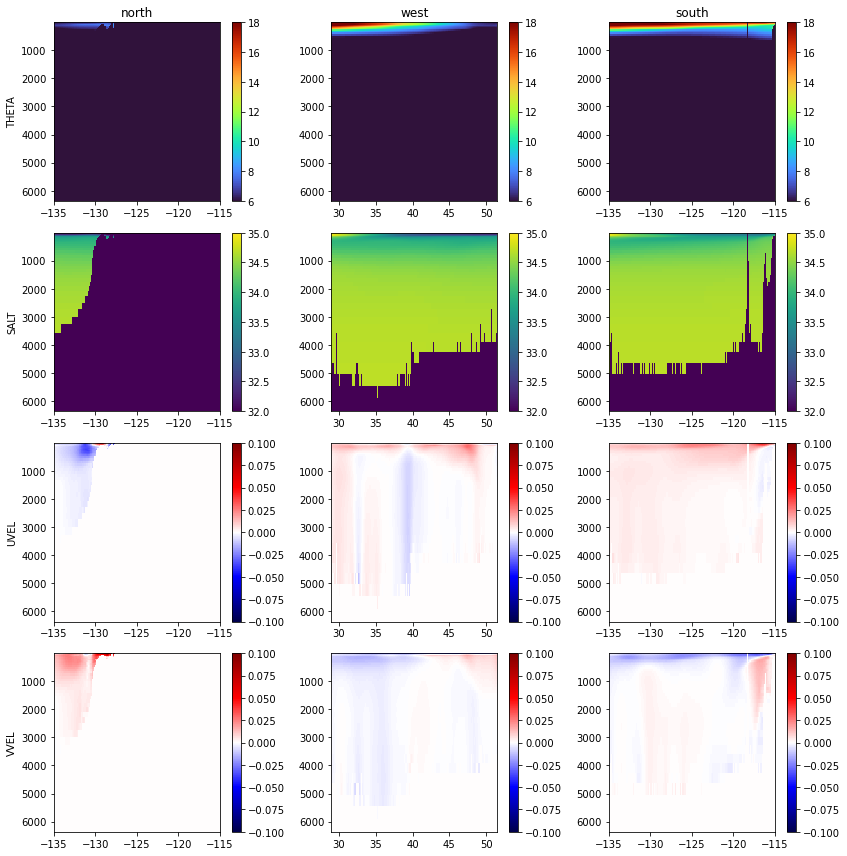

In [16]:
fig = plt.figure(figsize=(12,12))
plot_year = 2008

plot_counter = 0
for i in range(len(variable_names)):
    variable_name = variable_names[i]
    
    for boundary in boundary_list:
        
        boundary_grid = np.fromfile(os.path.join(input_dir,'obcs',variable_name+'_'+boundary+'_'+str(plot_year)),'>f4')
    
        if boundary in ['west','east']:
            boundary_grid = boundary_grid.reshape((timesteps, np.shape(delR)[0],np.shape(XC)[0]))
            boundary_grid = boundary_grid[0, :, :] # choose just the first timestep for plotting
            if boundary=='west':
                x = YC[:,1]
            if boundary=='east':
                x = YC[:,-1]
        else:
            boundary_grid = boundary_grid.reshape((timesteps, np.shape(delR)[0],np.shape(XC)[1]))
            boundary_grid = boundary_grid[0, :, :] # choose just the first timestep for plotting
            if boundary=='north':
                x = XC[-1,:]
            if boundary=='south':
                x = XC[1,:]

        plot_counter += 1
        plt.subplot(len(variable_names),len(boundary_list),plot_counter)
        C = plt.pcolormesh(x, np.cumsum(delR), boundary_grid,
                           vmin=meta_dict[variable_names[i]][0],
                           vmax=meta_dict[variable_names[i]][1],
                           cmap=meta_dict[variable_names[i]][2])
        plt.colorbar(C,fraction=0.26)
        plt.gca().invert_yaxis()
    
        if plot_counter%3==1:
            plt.ylabel(variable_name)
        if plot_counter<4:
            plt.title(boundary)

plt.tight_layout()

plt.show()

Looks good! Now, with the initial conditions, external forcing conditions, and boundary conditions we have all of the input binaries needed to run our model.